# Adiabatic Evolution of Ising Hamiltonian with Quantum Circuit

We discussed that the adiabatic principle can be used to obtain the ground state of a difficult problem (e.g., Ising Hamiltonian) by starting with an easy problem (which for which we know the solution) and slowly moving toward the difficult solution. This means that we need to _drive our system forward in time_ with a time-dependent Hamiltonian. 
This is generally a difficult task, but we can leverage a quantum computer to do this for us!

By choosing $\hat{H}_0 = - \sum_i \sigma_i^x$, 
recall that the ground state of the Ising model can be prepared by the following sequence of time evolutions:
$$
\ket{\psi(t_f)} = U(4,3)U(3,2)U(2,1)U(1,0)\ket{\psi(0)}
$$
which is, 
$$
\ket{\psi(t)} = e^{\tfrac{-i}{\hbar}\hat{H}_1\Delta t}e^{\tfrac{-i}{\hbar}\left(.25\hat{H}_0+.75\hat{H}_1\right)\Delta t}e^{\tfrac{-i}{\hbar}\left(.5\hat{H}_0+.5\hat{H}_1\right)\Delta t}e^{\tfrac{-i}{\hbar}\left(.75\hat{H}_0+.25\hat{H}_1\right)\Delta t}e^{\tfrac{-i}{\hbar}\hat{H}_0\Delta t}\ket{\psi(0)},
$$
where $N\Delta t = t$.

Here the basic idea is to use a quantum computer to do this time evolution for us.  

### Trotterization
One trick we will use is `Trotterization`. For 2 operators $\hat{o}_1$ and $\hat{o}_2$, we can say the following two things:
- if $\hat{o}_1\hat{o}_2 = \hat{o}_2\hat{o}_1$, then $e^{a\left(\hat{o}_1 + \hat{o}_2\right)} = e^{a\hat{o}_1}e^{a\hat{o}_2}$
- if $\hat{o}_1\hat{o}_2 \neq \hat{o}_2\hat{o}_1$ but $a\ll 1$, then $e^{a\left(\hat{o}_1 + \hat{o}_2\right)} \approx e^{a\hat{o}_1}e^{a\hat{o}_2}$

Where we say that $\hat{o}_1$ and $\hat{o}_2$ `commute` if $\hat{o}_1\hat{o}_2 = \hat{o}_2\hat{o}_1$

## Initialization

From our discussion before, we saw that applying a Hadamard gate to the $\ket{0}$ state created the $\hat{+}$ state, 
which happened to be the +1 eigenstate of $\sigma_x$:
- $\sigma_x\ket{+} = \ket{+}$

As such, we can initialize our system in the ground state of $\hat{H}_0$ by simply applying a Hadamard to each qubit. 

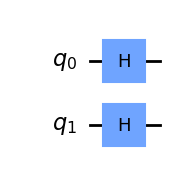

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from qiskit import *
from qiskit.tools.visualization import plot_histogram
from qiskit.tools.visualization import plot_bloch_multivector

sim = Aer.get_backend('statevector_simulator')

circ = QuantumCircuit(2,0)
circ.h(0)
circ.h(1)
circ.draw(output = 'mpl')

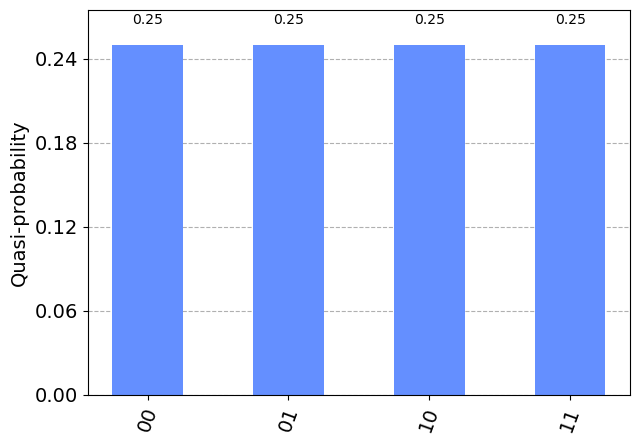

In [2]:
plot_histogram(execute(circ, backend = sim).result().get_counts(circ))

## First time step

How do we implement $e^{-i\hat{H}_0\Delta t}$ with a gate? Let's make things more concrete first, and consider a simple 2-site Ising problem. 
- $ \hat{H}_0 = - \sigma^x_0 - \sigma^x_1$
- $ \hat{H}_1 = J\sigma^z_0\sigma^z_1 + \mu\sigma^z_0 + \mu\sigma^z_1$
- $J = 1$
- $\mu = .1$

Because $\sigma_0^x$ and $\sigma_1^x$ act on different qubits, they commute, meaning that we can break this first time step up into 2 sequential steps exactly:
$$ 
e^{i\left(\sigma_0^x + \sigma_1^x\right)\Delta t} = e^{i\sigma_0^x\Delta t} e^{i\sigma_1^x\Delta t} 
$$

Let's choose a small time step, say $\Delta t = .1$. 
We can use the following quantum circuit to implement this time step:

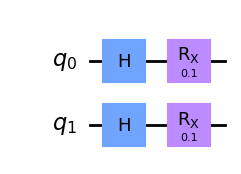

In [3]:
circ = QuantumCircuit(2,0)
circ.h(0)
circ.h(1)
circ.rx(.1,0)
circ.rx(.1,1)
circ.draw(output = 'mpl')

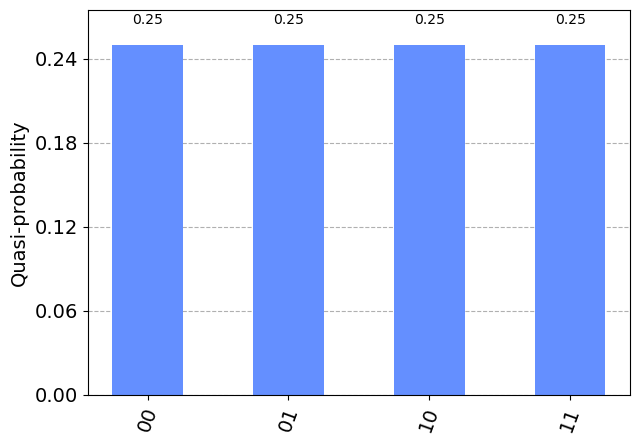

In [4]:
plot_histogram(execute(circ, backend = sim).result().get_counts(circ))

`Q`: Does this make sense that the probabilities stayed the same?


## Second time step

Now we must implement the following operator: $e^{-i\left(.75\hat{H}_0 + .25\hat{H}_1\right)\Delta t}$. 

Unfortunately, $\sigma^z\sigma^x \neq \sigma^z\sigma^x$ and so we can't exactly trotterize this. 
However, because $\Delta t \ll 1$, we can approximate this in a product form, and this will become increasingly more accurate as we take smaller time steps. 

$$ \hat{H}_0 = - \sigma^x_0 - \sigma^x_1$$
$$ \hat{H}_1 = J\sigma^z_0\sigma^z_1 + \mu\sigma^z_1 + \mu\sigma^z_1$$

$$
e^{-i\left(- .75\sigma^x_0 - .75\sigma^x_1 + .25 J\sigma^z_0\sigma^z_0 + .25\mu\sigma^z_1 + .25\mu\sigma^z_1\right)\Delta t}
\approx
e^{.75 i\sigma^x_0\Delta t} 
e^{.75 i\sigma^x_1\Delta t}
e^{-.25 i J\sigma^z_0\sigma^z_1 \Delta t}
e^{-.25 i \mu\sigma^z_0 \Delta t}
e^{-.25 i \mu\sigma^z_1 \Delta t}
$$

Notice here that we are using a new gate, `RZZ`. 
This is a 2-qubit gate that rotates about the product of two $\sigma^z$ operators.

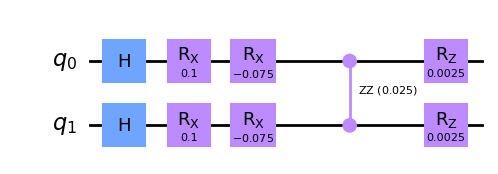

In [5]:
circ = QuantumCircuit(2,0)
# initialize
circ.h(0)
circ.h(1)

# time step 1
circ.rx(.1,0)
circ.rx(.1,1)

# time step 2
circ.rx(-.075,0)
circ.rx(-.075,1)
circ.rzz(.025,0,1)
circ.rz(.0025,0)
circ.rz(.0025,1)

circ.draw(output = 'mpl')

From here we can recognize the pattern and start to generalize with a function!


## Automate the circuit building

Because each step will have the same gates, but different angles, we can simply write a function to create the circuit. 

In [6]:
def form_circuit(beta, gamma, J=1, mu=0, n_qubits=2, pbc=True):
    """
    Form the circuit for adiabatic evolution
    
        H = J\sum_{ij} \sigma_i^z \sigma_j^z + \mu\sum_i\sigma_i^z
    """
    depth = len(beta)
    assert(len(beta) == len(gamma))
    
    # create circuit
    circ = QuantumCircuit(n_qubits,0)
    
    # add layer of hadamard gates
    for i in range(n_qubits):
        circ.h(i)
        
    for layer in range(depth):
        for i in range(n_qubits):
            circ.rx(beta[layer],i)
        for i in range(n_qubits-1):
            circ.rzz(-gamma[layer]*J,i,(i+1))
        if pbc:
            circ.rzz(-gamma[layer]*J,n_qubits-1,0)

        for i in range(n_qubits):
            circ.rz(gamma[layer]*mu,i)
    return circ    


## Plot for Arbitrary steps and qubits

Try out different numbers of steps and different Hamiltonians. 
- $\hat{H}(t) = \beta(t)\hat{H}_0 + \gamma(t)\hat{H}_1$

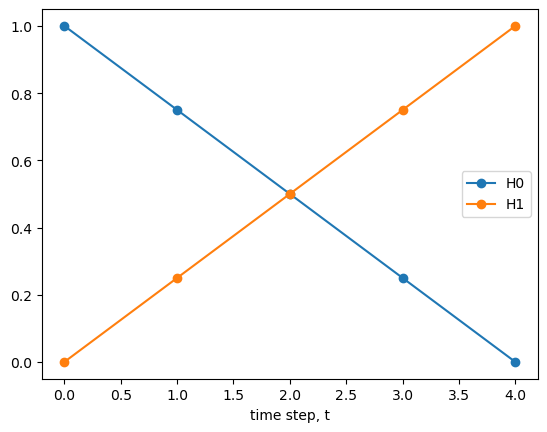

In [7]:
# create the adiabatic parameters
n_steps = 4
beta = []
gamma = []
for i in range(n_steps+1):
    beta.append(1-i/n_steps)
    gamma.append(i/n_steps)

plt.plot(beta, label="H0", marker="o")
plt.plot(gamma, label="H1", marker="o");
plt.xlabel("time step, t")
plt.legend();

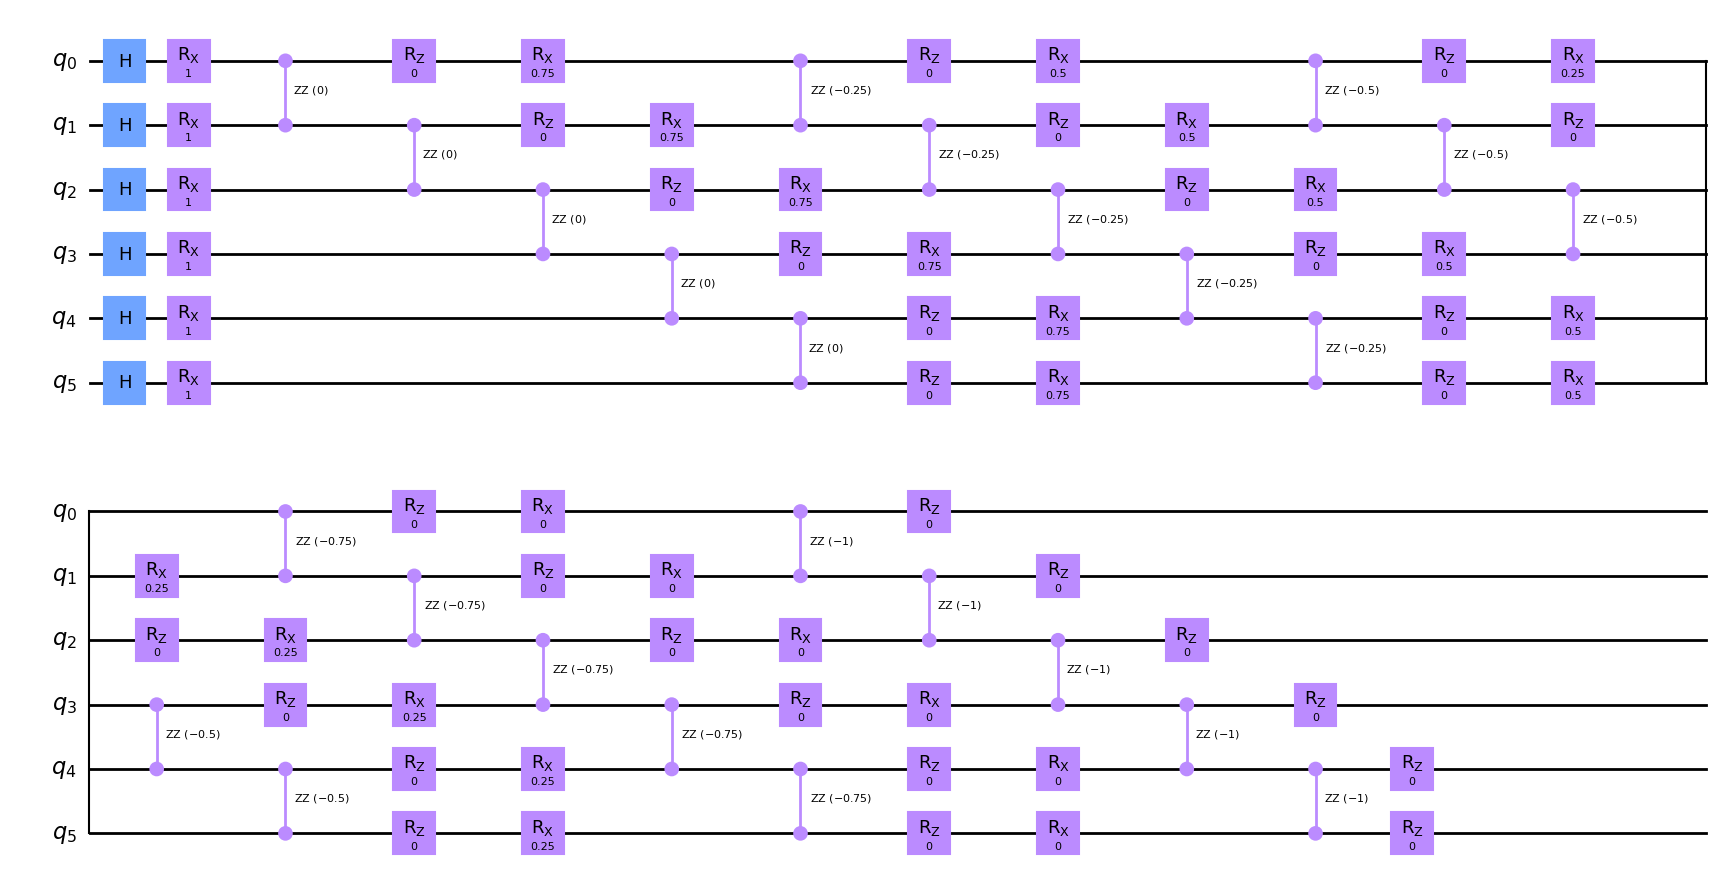

In [8]:
circ = form_circuit(beta, gamma, J=1, mu=.0, n_qubits=6, pbc=False)
circ.draw(output="mpl")

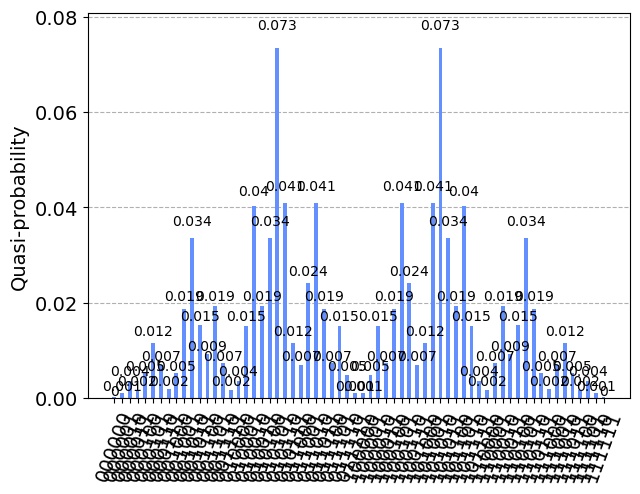

In [9]:
sim = Aer.get_backend('statevector_simulator')
result_sv = execute(circ, backend = sim).result()
state_vec = result_sv.get_statevector()
plot_histogram(result_sv.get_counts(circ))

In [10]:
samples = result_sv.get_counts(circ)
max(samples, key=samples.get)

'010101'